# Figure 6, Panels H and I – Make subnetworks

In [1]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import networkx as nx

from scipy.io import mmread
from scipy.sparse import csr_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

which: no R in (/apps/software/standard/core/jupyterlab/3.6.3-py3.11:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/sbin:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin:/home/apc5un/bedtools2/bin:/opt/mam/9.1.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/current/bin:/opt/singularity/current/bin:/opt/rci/bin:/share/rci_apps/common/bin:/share/resources/HPCtools:/opt/mam/current/bin:/opt/apptainer/current/bin)


'0.14.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

#### Load links and remove Mef2c connections from KO

In [4]:
def remove_and_filter(links_df, genes_to_remove, num_edges):
    for g in genes_to_remove:
        links_df = links_df.drop(links_df[links_df.source=='Mef2c'].index)
        links_df = links_df.drop(links_df[links_df.target=='Mef2c'].index)
        
    return links_df.sort_values('coef_abs', ascending=False).iloc[:num_edges]

In [5]:
thresh_num = 12000

links_wt_e85 = co.load_hdf5(file_path="./data/celloracle/e85/WT_cardiac-subset-links.celloracle.links")
links_ko_e85 = co.load_hdf5(file_path="./data/celloracle/e85/KO_cardiac-subset-links.celloracle.links")

links_wt_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num)
links_ko_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num+1000)

links_ko_e85.filtered_links['IFT-CMs_KO'] = remove_and_filter(links_ko_e85.filtered_links['IFT-CMs_KO'], ['Mef2c'], thresh_num)
links_ko_e85.filtered_links['V-CMs_KO'] = remove_and_filter(links_ko_e85.filtered_links['V-CMs_KO'], ['Mef2c'], thresh_num)

In [6]:
def return_adata_raw(timepoint):
    adata = sc.read_h5ad(f'data/adata_objects/{timepoint}_subset.h5ad')
    
    if timepoint == 'e85':
        names = ['pSHF_WT','pSHF_KO', 'aSHF_WT', 'aSHF_KO', 'IFT-CMs_WT', 'IFT-CMs_KO', 'V-CMs_WT', 
                 'V-CMs_KO', 'OFT-CMs_WT', 'OFT-CMs_KO', 'PhM_WT', 'PhM_KO', 'LPM_WT', 'LPM_KO', 
                 'PostM_WT', 'PostM_KO', 'MixM_WT', 'MixM_KO', 'C16_WT', 'C16_KO']
    elif timepoint == 'e9':
        names = ['SHF_WT', 'SHF_KO', 'Pe_WT', 'Pe_KO', 'VP_WT', 'VP_KO', 'CMs-A_WT', 'CMs-A_KO', 
                        'CMs-AVC_WT', 'CMs-AVC_KO', 'CMs-V_WT', 'CMs-V_KO', 'CMs-OFT_WT', 'CMs-OFT_KO', 
                        'PhM_WT', 'PhM_KO', 'C11_WT', 'C11_KO']        
    else:
        return
    
    mapping_dict = dict(zip(range(0, len(names)), names))
    adata.obs['celltype_x_genotype'] = adata.obs['cell_type_pool_x_genotype'].map(mapping_dict)    
    
    if timepoint == 'e9':
        adata.obs.loc[adata.obs['celltype_x_genotype'] == 'CMs-AVC_WT', 'celltype_x_genotype'] = 'CMs-A_WT'
    
    
    raw_mtx = mmread(f"./data/adata_objects/{timepoint}_matrix.mtx")
    raw_cells = pd.read_csv(f"./data/adata_objects/{timepoint}_raw_cells.csv", header=None)
    raw_genes = pd.read_csv(f"./data/adata_objects/{timepoint}_raw_genes.csv", header=None)
    x = pd.DataFrame(raw_mtx.toarray()).astype('float64')
    x.index = raw_genes.values.T[0]

    adata.X = x.loc[adata.var_names, :].values.T

    sc.pp.normalize_per_cell(adata)

    adata.raw = adata
    adata.layers["raw_count"] = adata.raw.X.copy()
    
    return adata

#### Set timepoint and load adata with raw readouts (req'd for DEG)

In [7]:
timepoint = 'e85'
adata = return_adata_raw(timepoint)

In [8]:
chamber = 'IFT'

# Filter the data to include only the relevant groups
if timepoint == 'e85':
    adata_subset = adata[adata.obs['celltype_x_genotype'].isin([f'{chamber}-CMs_KO', f'{chamber}-CMs_WT'])]
elif timepoint == 'e9':
    adata_subset = adata[adata.obs['celltype_x_genotype'].isin([f'CMs-{chamber}_KO', f'CMs-{chamber}_WT'])]
else:
    print('did not filter data')
    
# adata_subset.X = adata_subset.X + 8

sc.tl.rank_genes_groups(adata_subset, groupby='celltype_x_genotype', method='wilcoxon')
# sc.tl.rank_genes_groups(adata_subset, groupby='celltype_x_genotype', method='wilcoxon', use_raw=False)

# Extract the results into a DataFrame
# import pandas as pd
if timepoint == 'e85':
    de_results = pd.DataFrame(
        {
            'genes': adata_subset.uns['rank_genes_groups']['names'][f'{chamber}-CMs_KO'],
            'logfoldchanges': adata_subset.uns['rank_genes_groups']['logfoldchanges'][f'{chamber}-CMs_KO'],
            'pvals': adata_subset.uns['rank_genes_groups']['pvals'][f'{chamber}-CMs_KO'],
            'pvals_adj': adata_subset.uns['rank_genes_groups']['pvals_adj'][f'{chamber}-CMs_KO']
        }
    )
elif timepoint == 'e9':
    de_results = pd.DataFrame(
        {
            'genes': adata_subset.uns['rank_genes_groups']['names'][f'CMs-{chamber}_KO'],
            'logfoldchanges': adata_subset.uns['rank_genes_groups']['logfoldchanges'][f'CMs-{chamber}_KO'],
            'pvals': adata_subset.uns['rank_genes_groups']['pvals'][f'CMs-{chamber}_KO'],
            'pvals_adj': adata_subset.uns['rank_genes_groups']['pvals_adj'][f'CMs-{chamber}_KO']
        }
    )
else:
    print('oops2')
    
de_results['genes'] = de_results['genes'].apply(lambda x: x[0] if isinstance(x, tuple) else x)

In [9]:
de_results

,genes,logfoldchanges,pvals,pvals_adj
0,Uty,31.867439,6.577047e-125,1.644262e-121
1,Igfbp5,17.784737,2.087806e-85,2.261879e-82
2,Rps29,5.951621,3.512396e-58,2.195248e-55
3,Rps28,5.329119,5.104754e-58,2.835974e-55
4,Rpl39,4.874779,9.436468e-55,3.629411e-52
...,...,...,...,...
4995,Hsp90aa1,-12.130846,3.198703e-70,2.284788e-67
4996,Pde4d,-6.622720,3.216850e-79,2.680708e-76
4997,Tnnc1,-7.972288,2.261879e-85,2.261879e-82
4998,Tsix,-10.609648,1.186310e-103,1.977183e-100


## Load in the networks

I have saved the CellOracle networks as .csv files. They have the following columns:
- `source` – a transcription factor
- `target` – the gene being targeted by the TF
- `coef_mean` – the magnitude of activation (+) or repression (-)
- `coef_abs` – absolute value of `coef_mean`
- `p` – p-value
- `-logp` – negative log p value

### Figures 4 – Subnetworks

This is the `plot_subnetwork()` function. It will return a `networkx` network for visualization.

In [10]:
def plot_subnetwork(network, tf_genes, targets):
    graph_df = {'source': [],
                 'target': [],
                 'weight': [],
                 'edge_cols': []}
    
    for curr_gene in tf_genes:
        curr_gene_df = network[network['source'] == curr_gene]
        gene_df_targs = curr_gene_df[curr_gene_df['target'].isin(targets)]

        for index, row in gene_df_targs.iterrows():
            graph_df['source'].append(row['source'])
            graph_df['target'].append(row['target'])
            graph_df['weight'].append(row['coef_mean'])
            if row['coef_mean'] > 0:
                graph_df['edge_cols'].append('green')
            else:
                graph_df['edge_cols'].append('red')

    graph_df = pd.DataFrame(graph_df)

    G = nx.from_pandas_edgelist(graph_df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    
    from pyvis.network import Network
    net = Network(notebook=True, directed=True)
    net.from_nx(G)

    for edge in net.edges:
        if edge['width'] > 0:
            edge['color'] = 'grey'
            edge['arrowStrikethrough'] = False
        else:
            edge['color'] = 'red'
            edge['arrows'] = {"to": {"enabled": True, "type": "bar", "scaleFactor":.4}}

        edge['value'] = np.abs(edge['width'])


    for node in net.nodes:
        if node['id'] in tf_genes:
            node['shape'] = 'diamond'
            node['color'] = 'grey'
            node['size'] = 10
            node['font'] = {'size': 40, 'color': 'black'}
        else:
            node['color'] = 'grey' # Black is neither
            node['font'] = {'size': 16, 'color': 'black'}
            node['size'] = 2
            
        if node['id'] in ['Gata4', 'Nr2f2']:
            node['shape'] = 'diamond'
            node['color'] = 'grey'
            node['size'] = 20
            node['font'] = {'size': 40, 'color': 'black'}
        

    G_act = nx.from_pandas_edgelist(graph_df[graph_df.weight > 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    G_inact = nx.from_pandas_edgelist(graph_df[graph_df.weight < 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
            
    return net, G_act, G_inact

### Visualize a subnetwork

Visualizing networks is very helpful, but it is difficult to make sense of the CellOracle network when observed in its entirety. I find it useful to focus in on a handfull of genes/transcription factors of interest. We have discussed starting with a few of the sarcomeric proteins that we know to be differentially expressed. 

Add/remove genes from the `tf_genes` and `targets` list to visualize the subnetworks of interest.

In [11]:
de_results.sort_values('pvals', ascending=True)
de_subset = de_results[de_results.pvals <1E-7]

In [12]:
de_subset = de_subset.sort_values('pvals_adj')

In [13]:
x = links_wt_e85.filtered_links['IFT-CMs_WT']
x.to_csv('./data/tmp_e85-wt.csv')

In [15]:
tf_genes = ['Mef2a', 'Mef2c', 'Nr2f2', 'Tbx5', 'Gata4', 'Meis2', 'Plagl1',
            'Isl1', 'Pitx2', 'Tbx20', 'Hand2', 'Nkx2-5']

targets = list(de_subset.genes.values)[:100]
targets += tf_genes

net, G_act, G_inact = plot_subnetwork(links_wt_e85.filtered_links['IFT-CMs_WT'], tf_genes, targets)
net.show('net.html')

net.html


In [16]:
x = links_ko_e85.filtered_links['IFT-CMs_KO']
x.to_csv('./data/tmp_e85-ko.csv')

net, G_act, G_inact = plot_subnetwork(links_ko_e85.filtered_links['IFT-CMs_KO'], tf_genes, targets)
# net, G_act, G_inact = plot_subnetwork(links_ko_e85.filtered_links['V-CMs_KO'], tf_genes, targets)
net.show('net.html')

net.html


### Panel I – Nr2f2 AND Gata4 direct connections

In [30]:
def get_gene_targets(tf, links_wt, links_ko):
    wt_targets = links_wt[links_wt.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    ko_targets = links_ko[links_ko.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    
    intersect_targets = [x for x in wt_targets if x in ko_targets]
    
    wt_only_targets = [x for x in wt_targets if x not in ko_targets]

    ko_only_targets = [x for x in ko_targets if x not in wt_targets]
    
    return intersect_targets, wt_only_targets, ko_only_targets

tf = 'Gata4'
wt_or_ko = 'wt'

links_wt = links_wt_e85.filtered_links['IFT-CMs_WT']
links_ko = links_ko_e85.filtered_links['IFT-CMs_KO']

# links_wt = links_wt_e9.filtered_links['CMs-A_WT']
# links_ko = links_ko_e9.filtered_links['CMs-A_KO']

intersect_targets, wt_targets, ko_targets = get_gene_targets(tf, links_wt, links_ko)

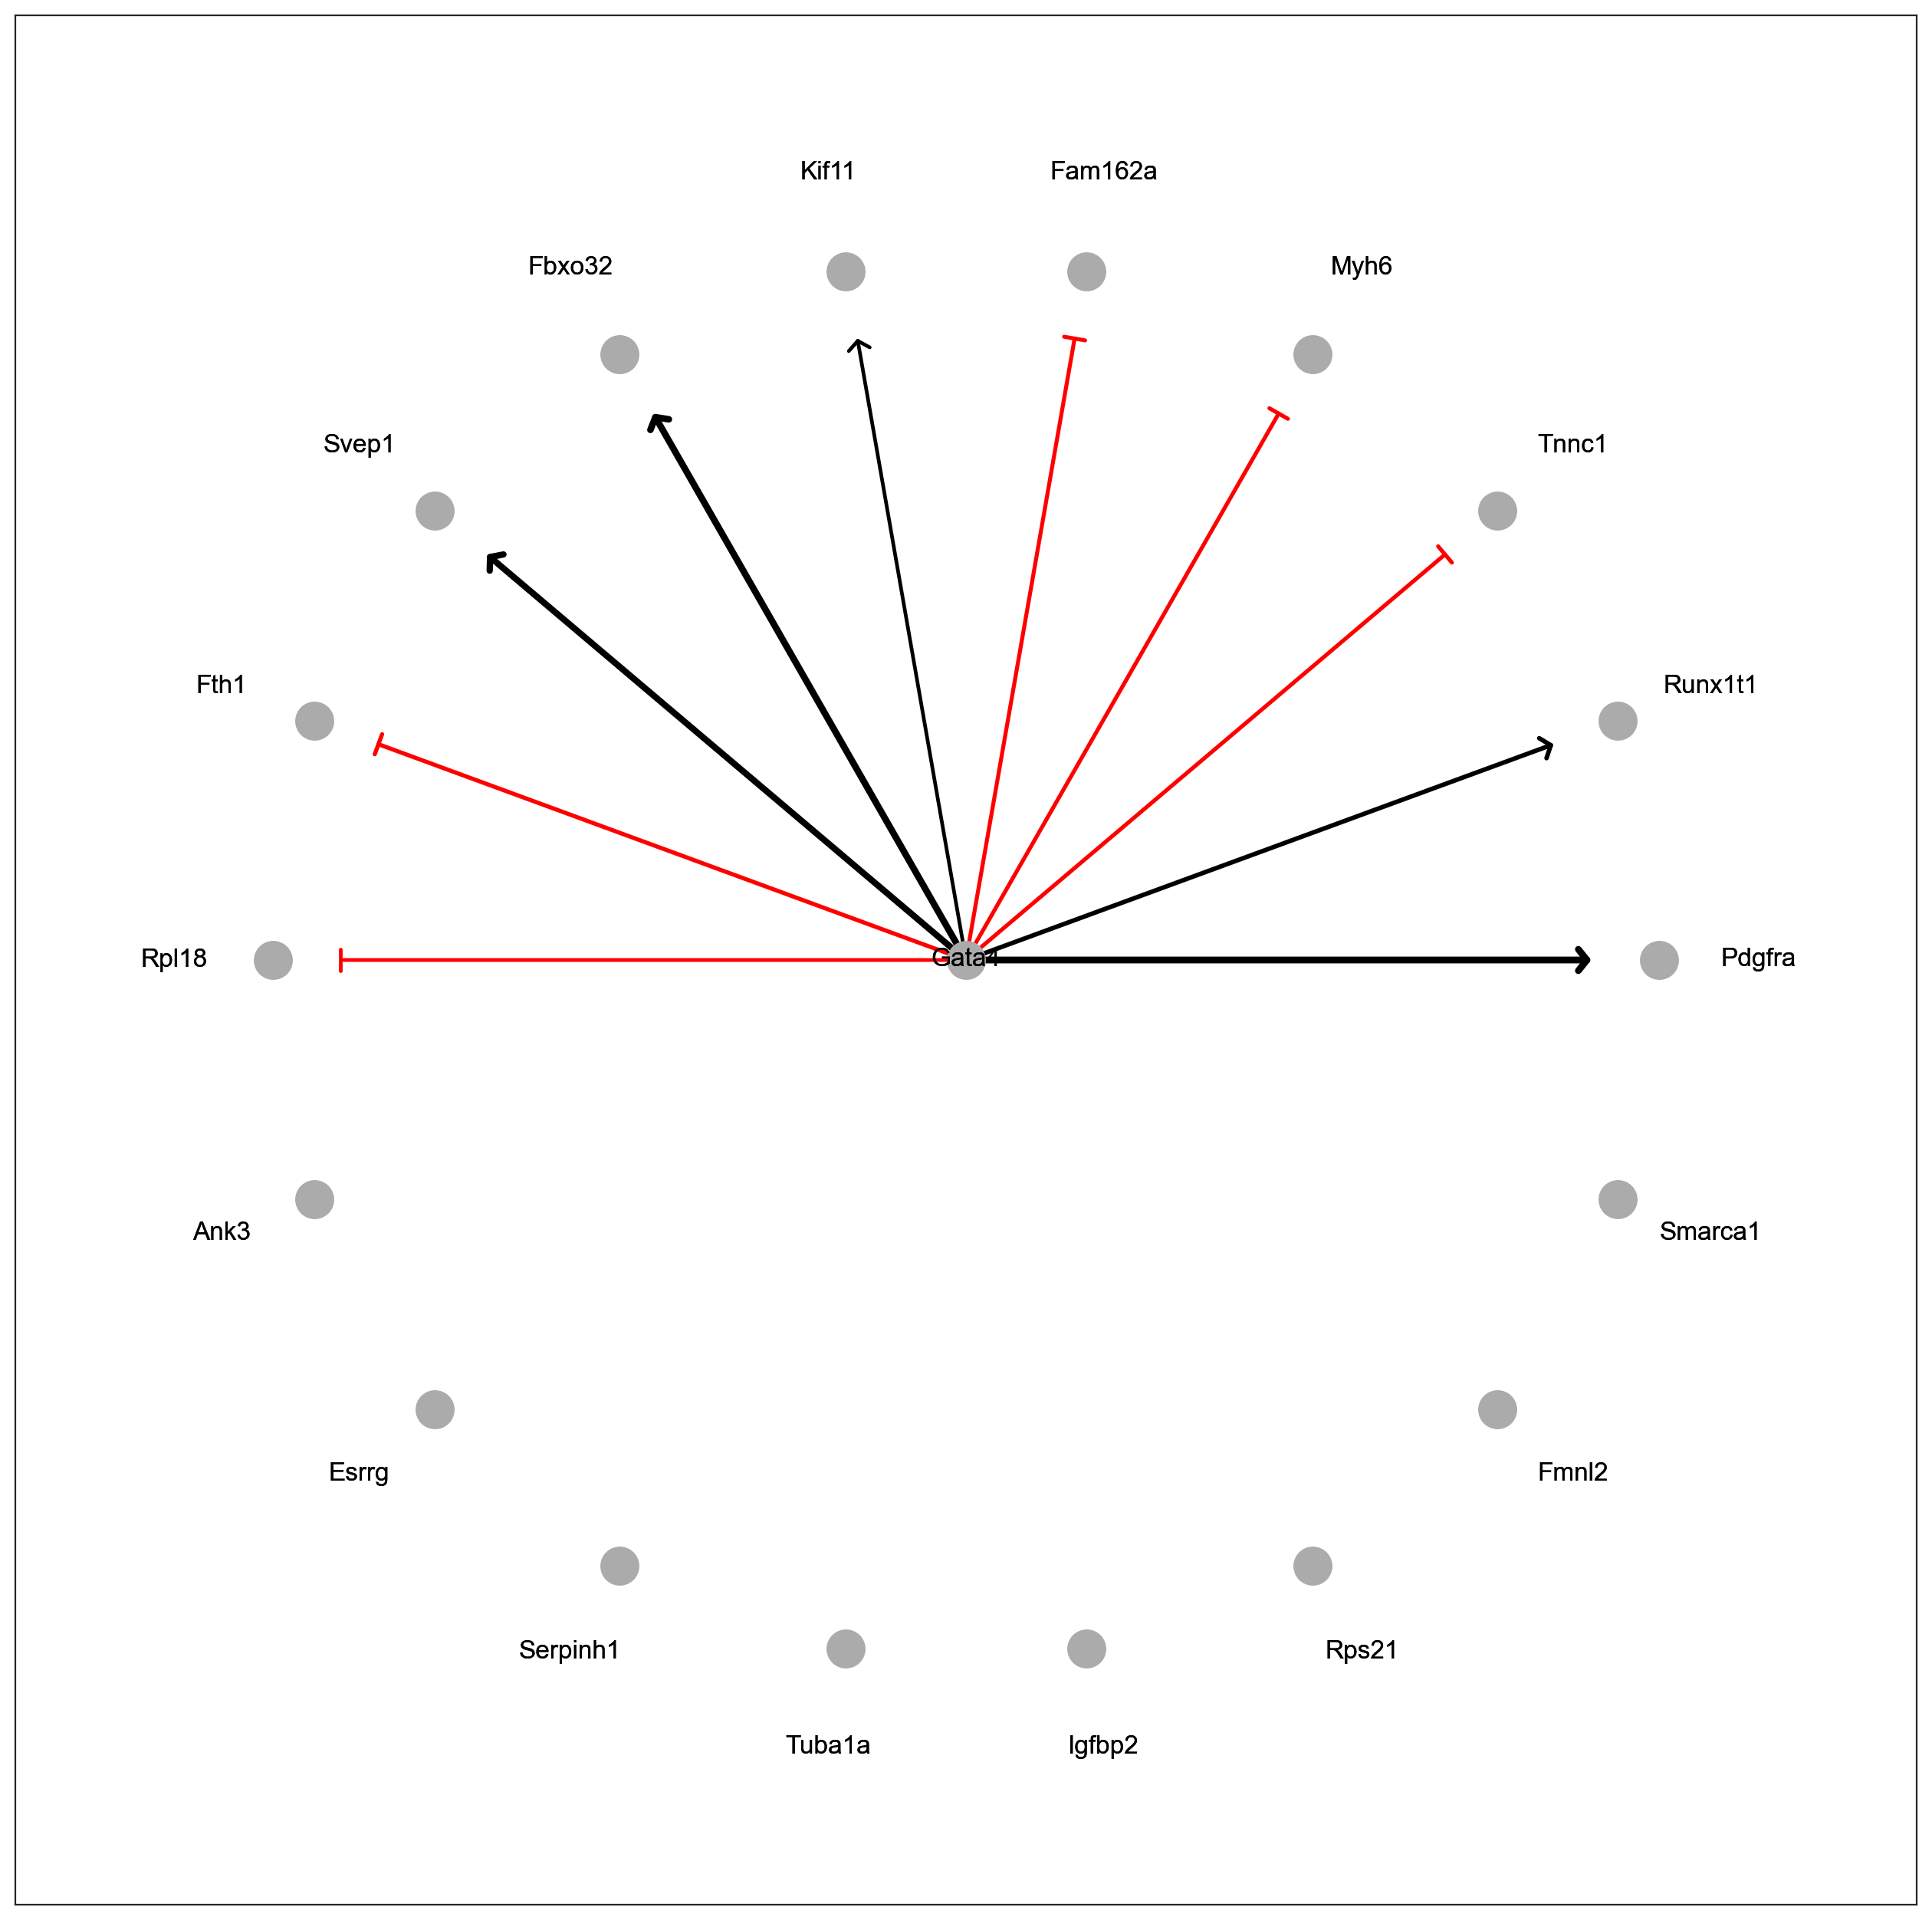

In [31]:
import networkx as nx
import numpy as np
import math
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rc('font', family='Arial')
fig, ax = plt.subplots(figsize=(16, 16))

all_nodes = wt_targets + intersect_targets +  ko_targets

G_act = nx.DiGraph()
G_act.add_nodes_from(all_nodes)
G_inhib = nx.DiGraph()
G_inhib.add_nodes_from(all_nodes)

pos = nx.circular_layout(G_act.subgraph(all_nodes))

G_act.add_node(tf)
G_inhib.add_node(tf)

if wt_or_ko == 'wt':
    tf_links = links_wt[links_wt.source == tf]
else:
    tf_links = links_ko[links_ko.source == tf]
    
for x in tf_links.target:
    connection = tf_links[tf_links.target == x]
    if connection.coef_mean.values[0] < 0:
        G_inhib.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='red')
    else:
        G_act.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='black')
        

for i, G in enumerate([G_act, G_inhib]):
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight']*4 for u,v in edges]
    center_node = tf
    pos[center_node] = np.array([0, 0])
    
    pos_higher = nx.rescale_layout_dict(pos, 16)
    nx.draw_networkx_labels(G, pos_higher)
    
    pos_lower = nx.rescale_layout_dict(pos, 13)
    # nx.draw_networkx_nodes(G, pos, node_color="#005D32")

    if i == 0:
        nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('->', head_length=0.4, head_width=0.5))
    else:
        nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('|-|', widthA=0, angleA=0, widthB=.5, angleB=0))


pos_mid = nx.rescale_layout_dict(pos, 14)
nx.draw_networkx_nodes(G, pos_mid, node_color="#ababab")

x_values, y_values = zip(*pos_higher.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.1
plt.xlim(float(x_min - x_margin), float(x_max + x_margin))

y_max = max(y_values)
y_min = min(y_values)
y_margin = (y_max - y_min) * 0.1
plt.ylim(float(y_min - y_margin), float(y_max + y_margin))
plt.savefig(f"./data/{tf}-{wt_or_ko}.pdf", format='pdf')

## EXPLORE

In [17]:
thresh_num = 12000

links_wt_e85 = co.load_hdf5(file_path="./data/celloracle/e85/WT_cardiac-subset-links.celloracle.links")
links_ko_e85 = co.load_hdf5(file_path="./data/celloracle/e85/KO_cardiac-subset-links.celloracle.links")

links_wt_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num)
links_ko_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num+1000)

links_ko_e85.filtered_links['IFT-CMs_KO'] = remove_and_filter(links_ko_e85.filtered_links['IFT-CMs_KO'], ['Mef2c'], thresh_num)

links_wt = links_wt_e85.filtered_links['IFT-CMs_WT']
links_ko = links_ko_e85.filtered_links['IFT-CMs_KO']

gene = 'Nr2f2'

print(len(links_wt[links_wt.source == gene]))
len(links_ko[links_ko.source == gene])

29


37

In [18]:
links_wt_e9 = co.load_hdf5(file_path="./data/celloracle/e9/WT_cardiac-subset-links.celloracle.links")
links_ko_e9 = co.load_hdf5(file_path="./data/celloracle/e9/KO_cardiac-subset-links.celloracle.links")

thresh_num = 4000

links_wt_e9.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num)
links_ko_e9.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num+1000)

links_ko_e9.filtered_links['CMs-A_KO'] = remove_and_filter(links_ko_e9.filtered_links['CMs-A_KO'], ['Mef2c'], thresh_num)
links_ko_e9.filtered_links['CMs-V_KO'] = remove_and_filter(links_ko_e9.filtered_links['CMs-V_KO'], ['Mef2c'], thresh_num)

In [19]:
adata.obs['celltype_x_genotype'].unique()

array(['PhM_KO', 'pSHF_KO', 'IFT-CMs_KO', 'LPM_KO', 'MixM_KO',
       'OFT-CMs_KO', 'V-CMs_KO', 'aSHF_KO', 'PostM_KO', 'C16_KO',
       'V-CMs_WT', 'OFT-CMs_WT', 'MixM_WT', 'LPM_WT', 'pSHF_WT',
       'aSHF_WT', 'IFT-CMs_WT', 'PhM_WT', 'PostM_WT', 'C16_WT'],
      dtype=object)

5000 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


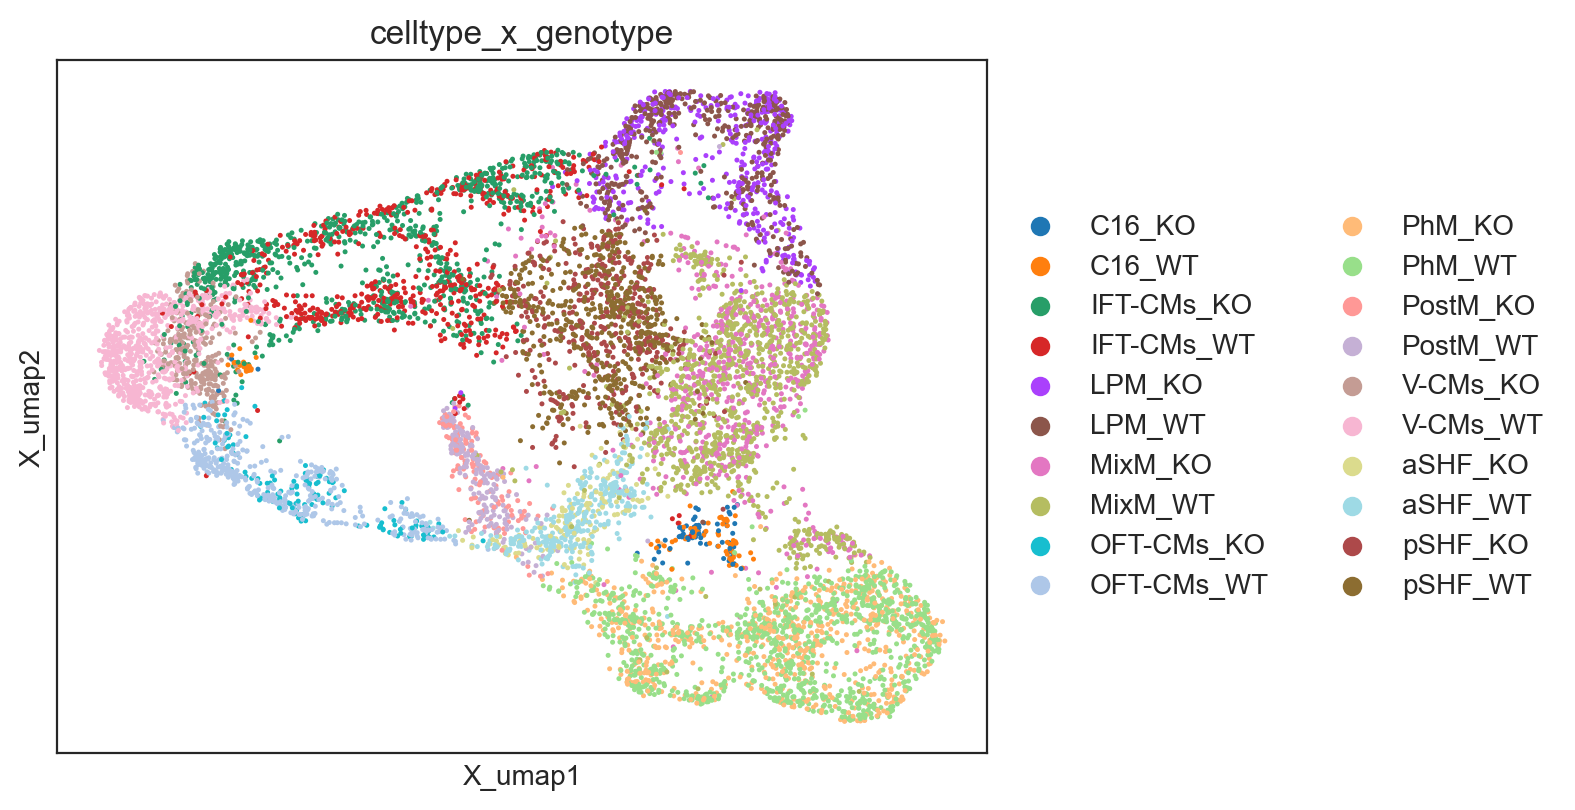

FileNotFoundError: [Errno 2] No such file or directory: 'data/base_grn_outputs/E85/WT_base_GRN_dataframe.parquet'

In [20]:
gene = 'Tnni1'
oracle = co.Oracle()
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="celltype_x_genotype",
                                   embedding_name="X_umap")

base_GRN_E85 = pd.read_parquet(f'data/base_grn_outputs/E85/WT_base_GRN_dataframe.parquet')
base_GRN_E9 = pd.read_parquet(f'data/base_grn_outputs/E9/WT_base_GRN_dataframe.parquet')

oracle.import_TF_data(TF_info_matrix=base_GRN_E85)
# print('Mef2c' in oracle.TFdict[gene])
# print(oracle.TFdict[gene])

# oracle.import_TF_data(TF_info_matrix=base_GRN_E9)
# print('Mef2c' in oracle.TFdict[gene])
# print(oracle.TFdict[gene])

In [21]:
gem_imputed = co.network_analysis.network_construction._adata_to_df(oracle.adata, "imputed_count")
cluster = 'IFT-CMs_WT'
cells_in_the_cluster_bool = (cluster_info == cluster)
gem_ = gem_imputed[cells_in_the_cluster_bool]

KeyError: 'imputed_count'

3.132090498363146


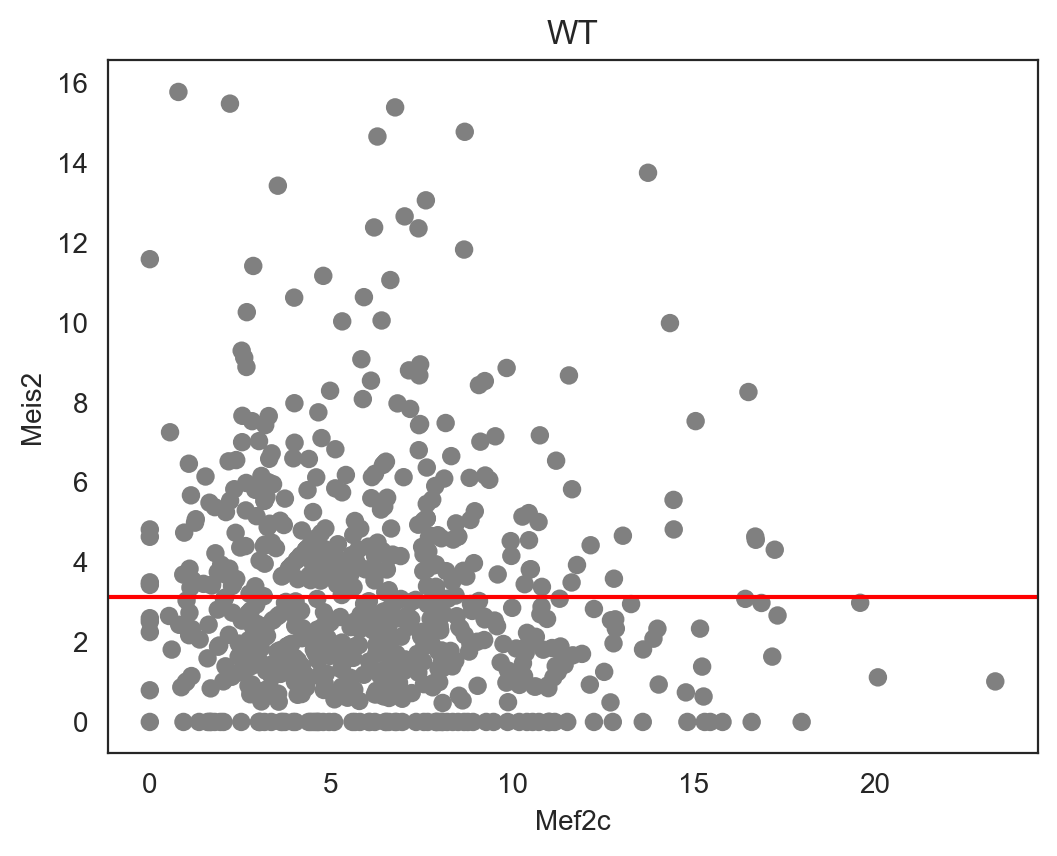

1.4099001593595093


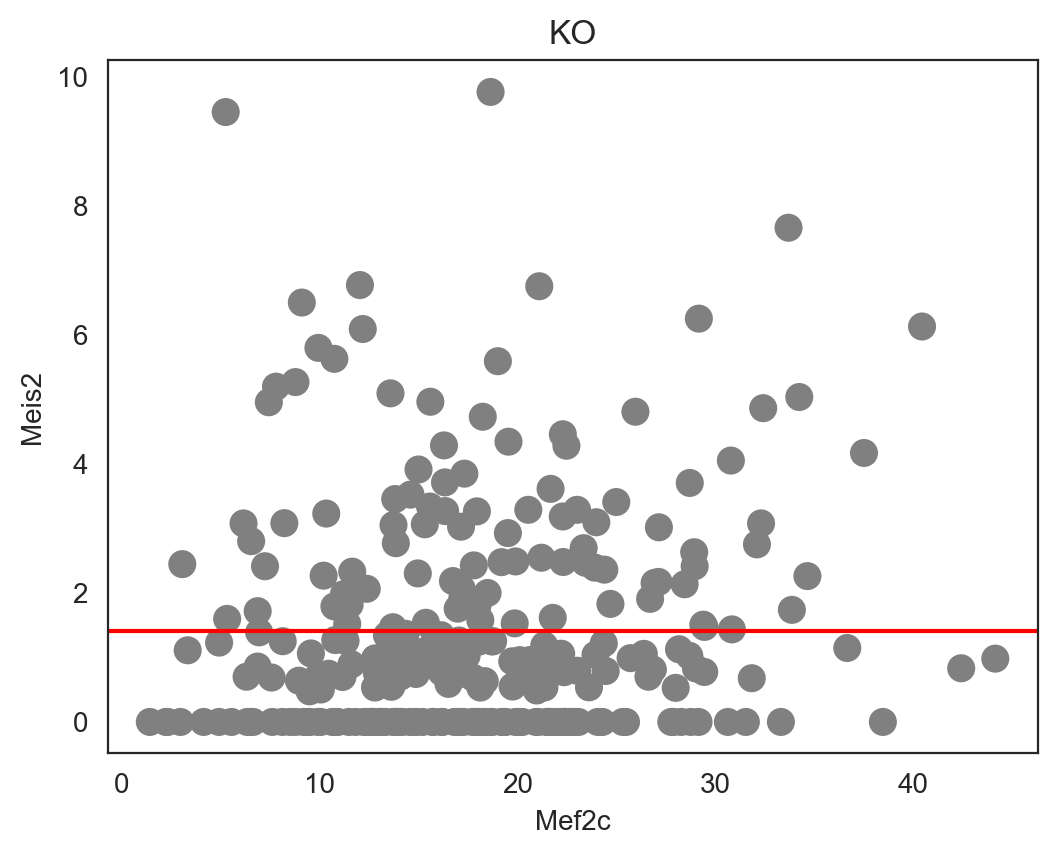

In [22]:
gene = 'Meis2'
subset_adata = adata[adata.obs['celltype_x_genotype'] == 'V-CMs_WT']
fig, ax = plt.subplots(1,1)
y_mean = subset_adata[:, gene].X.mean()
print(y_mean)
ax.axhline(y_mean, color='red')
sc.pl.scatter(subset_adata, x='Mef2c', y=gene, title='WT', ax=ax)


plt.show()

subset_adata = adata[adata.obs['celltype_x_genotype'] == 'V-CMs_KO']
fig, ax = plt.subplots(1,1)
y_mean = subset_adata[:, gene].X.mean()
ax.axhline(y_mean, color='red')
print(y_mean)
sc.pl.scatter(subset_adata, x='Mef2c', y=gene, title='KO', ax=ax)


In [23]:
de_results[de_results.genes.isin(['Tnnt2'])]

,genes,logfoldchanges,pvals,pvals_adj
4857,Tnnt2,-2.599087,4.111718e-09,5.453207e-08


In [24]:
gene = 'Wnt2'
x = links_wt_e85.filtered_links['IFT-CMs_WT']
# x = links_wt_e9.filtered_links['CMs-V_WT']
print(x[x.target == gene].sort_values('coef_mean').coef_mean.mean())
x[x.target == gene].sort_values('coef_mean')

0.0025507621


,source,target,coef_mean,coef_abs,p,-logp
188531,Elf1,Wnt2,-0.012157,0.012157,5.811836e-10,9.235687
188522,Ebf1,Wnt2,-0.011982,0.011982,8.326014e-11,10.079563
188564,Glis3,Wnt2,-0.011910,0.011910,6.207154e-11,10.207107
188554,E2f6,Wnt2,-0.011623,0.011623,4.263399e-12,11.370244
188548,Gli1,Wnt2,0.011739,0.011739,2.316421e-11,10.635183
188553,E2f5,Wnt2,0.013319,0.013319,1.993914e-15,14.700294
188558,Foxp1,Wnt2,0.013343,0.013343,4.824895e-09,8.316512
188537,Pbx3,Wnt2,0.015868,0.015868,3.547042e-15,14.450134
188524,Nr2f2,Wnt2,0.016360,0.016360,4.250787e-15,14.371531


In [25]:
y = links_ko_e85.filtered_links['V-CMs_KO']
# y = links_ko_e9.filtered_links['CMs-V_KO']
print(y[y.target == gene].sort_values('coef_mean').coef_mean.mean())
y[y.target == gene].sort_values('coef_mean')

0.00033104065


,source,target,coef_mean,coef_abs,p,-logp
187186,Zbtb1,Wnt2,-0.015739,0.015739,1.855362e-16,15.731571
187173,Sp4,Wnt2,-0.011492,0.011492,6.635809e-14,13.178106
187180,Zbtb7a,Wnt2,-0.010488,0.010488,1.794011e-13,12.746175
187196,E2f3,Wnt2,-0.009976,0.009976,1.035775e-13,12.984735
187182,Gli2,Wnt2,-0.009335,0.009335,3.385532e-16,15.470373
187191,Sp5,Wnt2,-0.008682,0.008682,3.464969e-11,10.460301
187189,Plagl1,Wnt2,-0.007952,0.007952,2.175105e-14,13.662520
187198,E2f6,Wnt2,0.006776,0.006776,3.924646e-09,8.406199
187176,Nrf1,Wnt2,0.007856,0.007856,4.950839e-12,11.305321
187205,Chd2,Wnt2,0.007921,0.007921,5.124180e-14,13.290376


In [26]:
set(x[x.target == gene]['source']).intersection(set(y[y.target == gene]['source']))

{'E2f6', 'Foxp1'}

## EXPLORE

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
oracle = co.Oracle()

5000 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


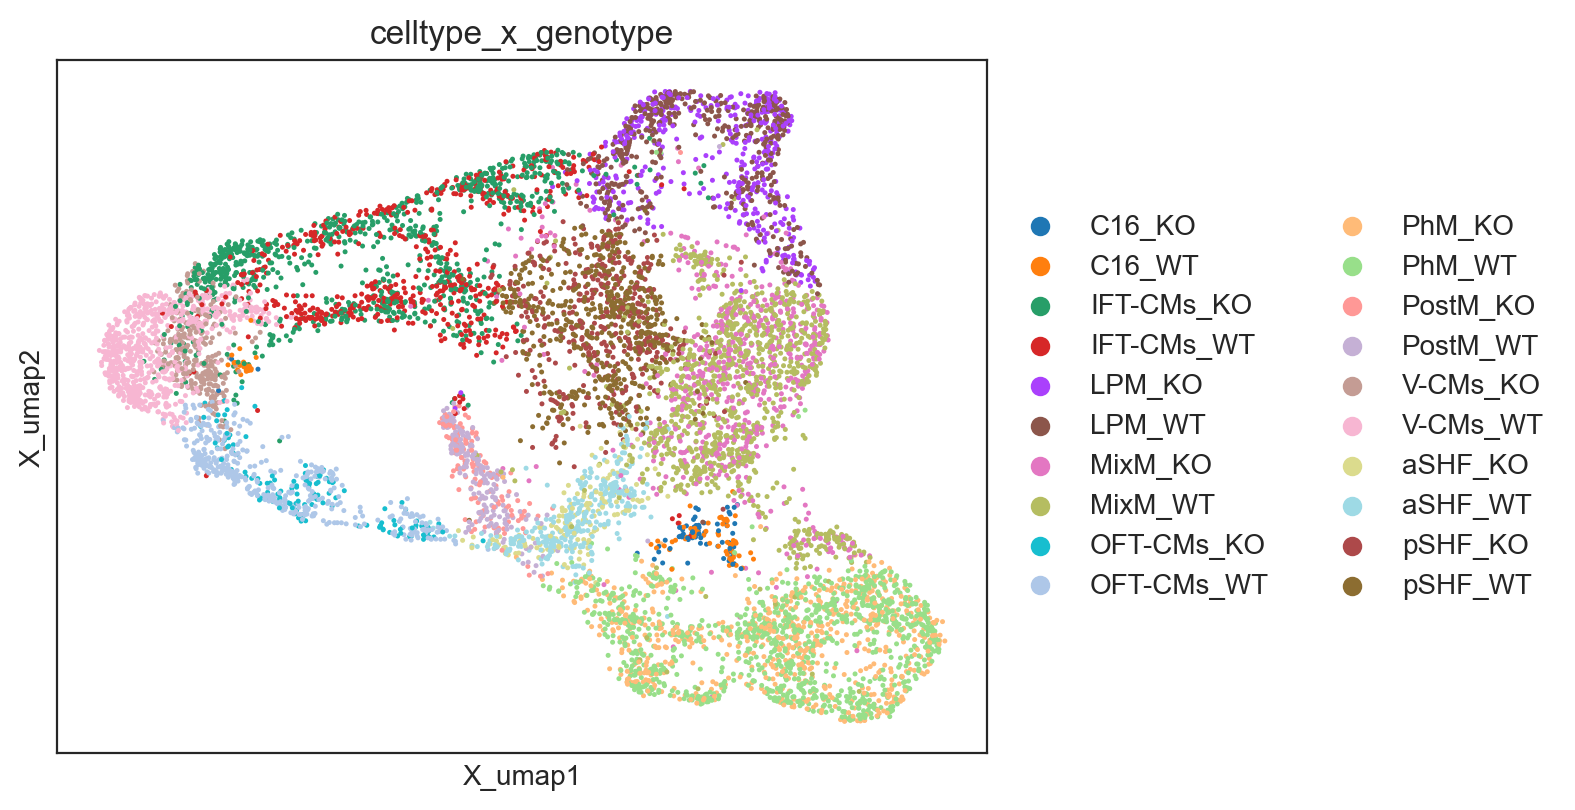

In [28]:
# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                               cluster_column_name="celltype_x_genotype",
                               embedding_name="X_umap")
timepoint = '85'
wt_or_ko = 'WT'
base_GRN = pd.read_parquet(f'data/base_grn_outputs/E{timepoint}/base_GRN_dataframe.parquet')
oracle.import_TF_data(TF_info_matrix=base_GRN)
    
# Perform PCA
oracle.perform_PCA()

# Select important PCs
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
n_comps = min(n_comps, 50)

n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)

oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                  b_maxl=k*4, n_jobs=4)

In [29]:
list(oracle.adata.obs.celltype_x_genotype.unique())

['PhM_KO',
 'pSHF_KO',
 'IFT-CMs_KO',
 'LPM_KO',
 'MixM_KO',
 'OFT-CMs_KO',
 'V-CMs_KO',
 'aSHF_KO',
 'PostM_KO',
 'C16_KO',
 'V-CMs_WT',
 'OFT-CMs_WT',
 'MixM_WT',
 'LPM_WT',
 'pSHF_WT',
 'aSHF_WT',
 'IFT-CMs_WT',
 'PhM_WT',
 'PostM_WT',
 'C16_WT']

681


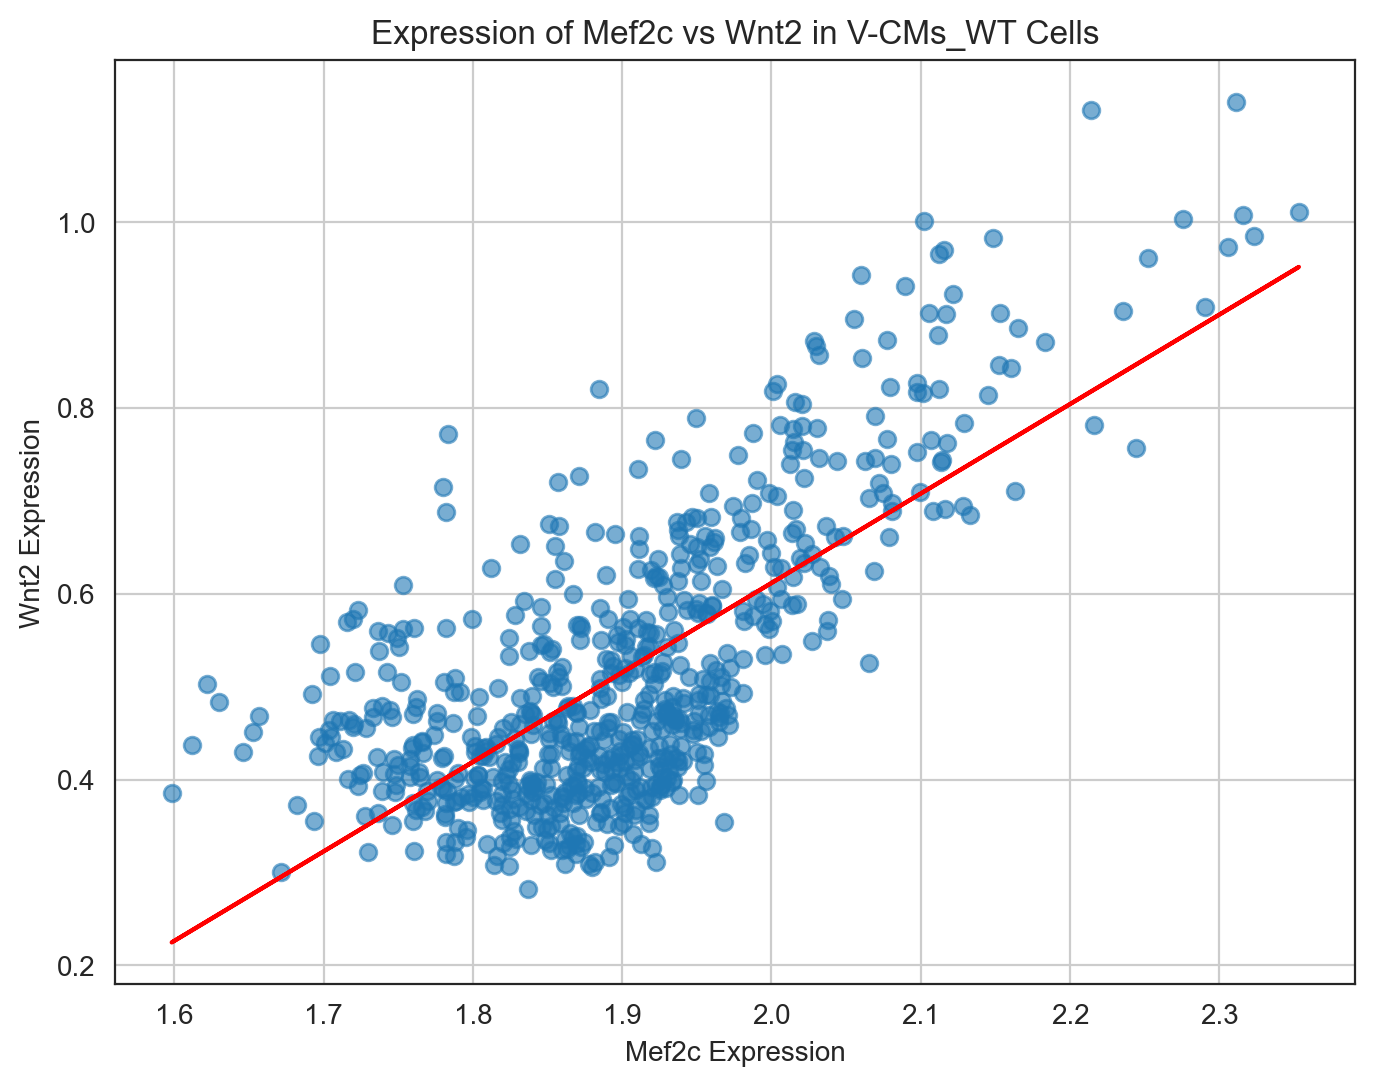

0.5075684379022711
681


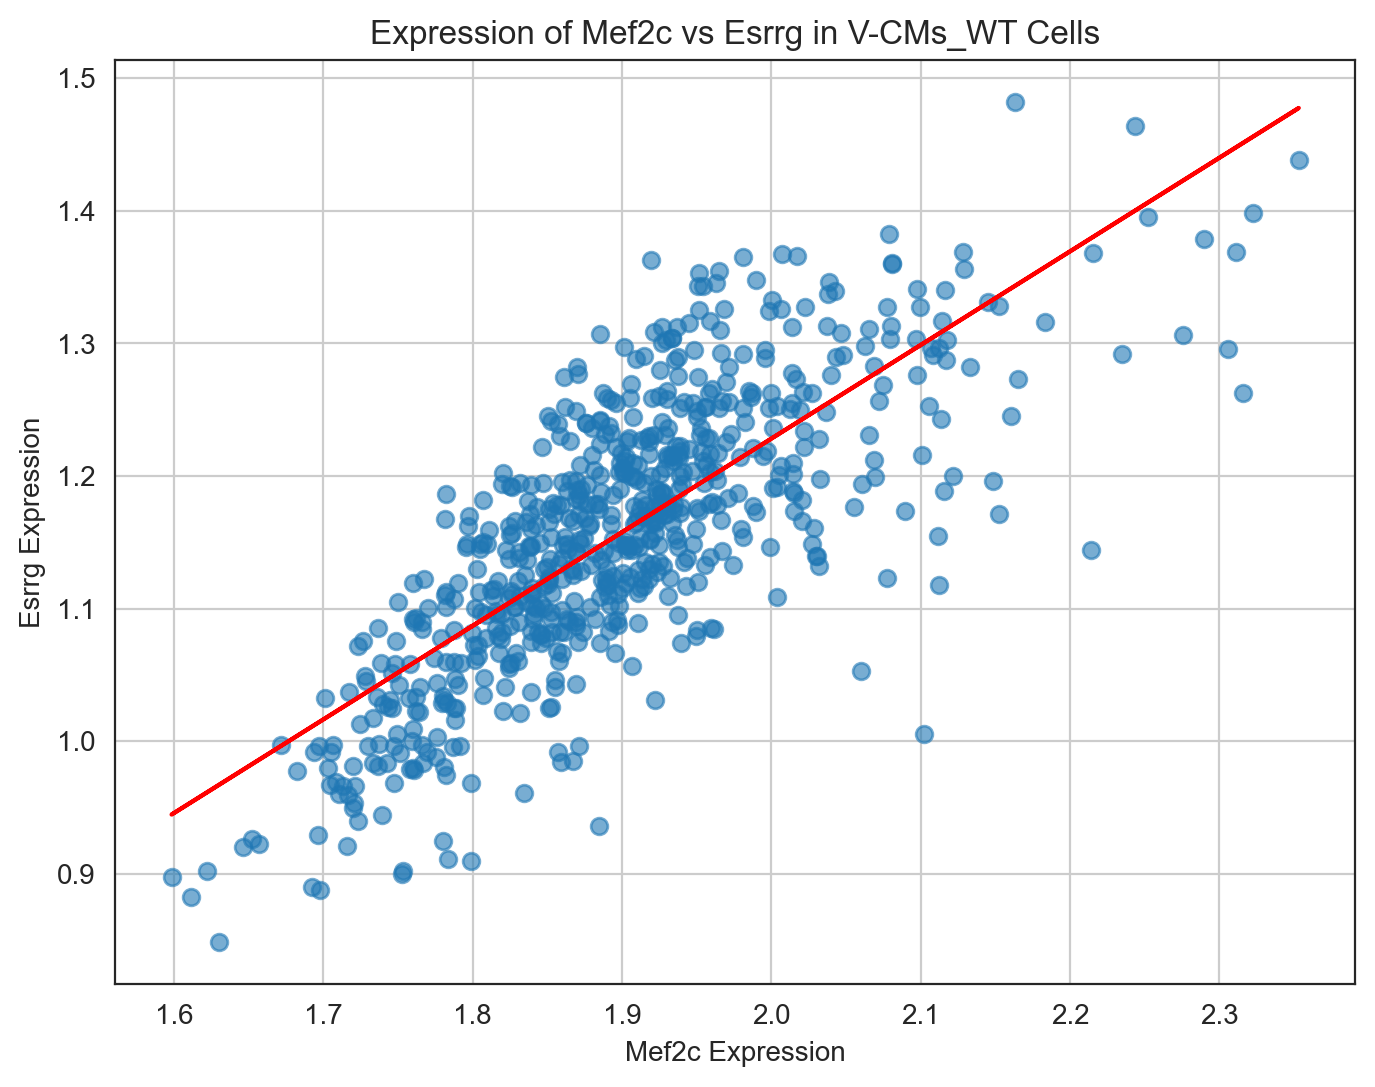

0.585852358665008
681


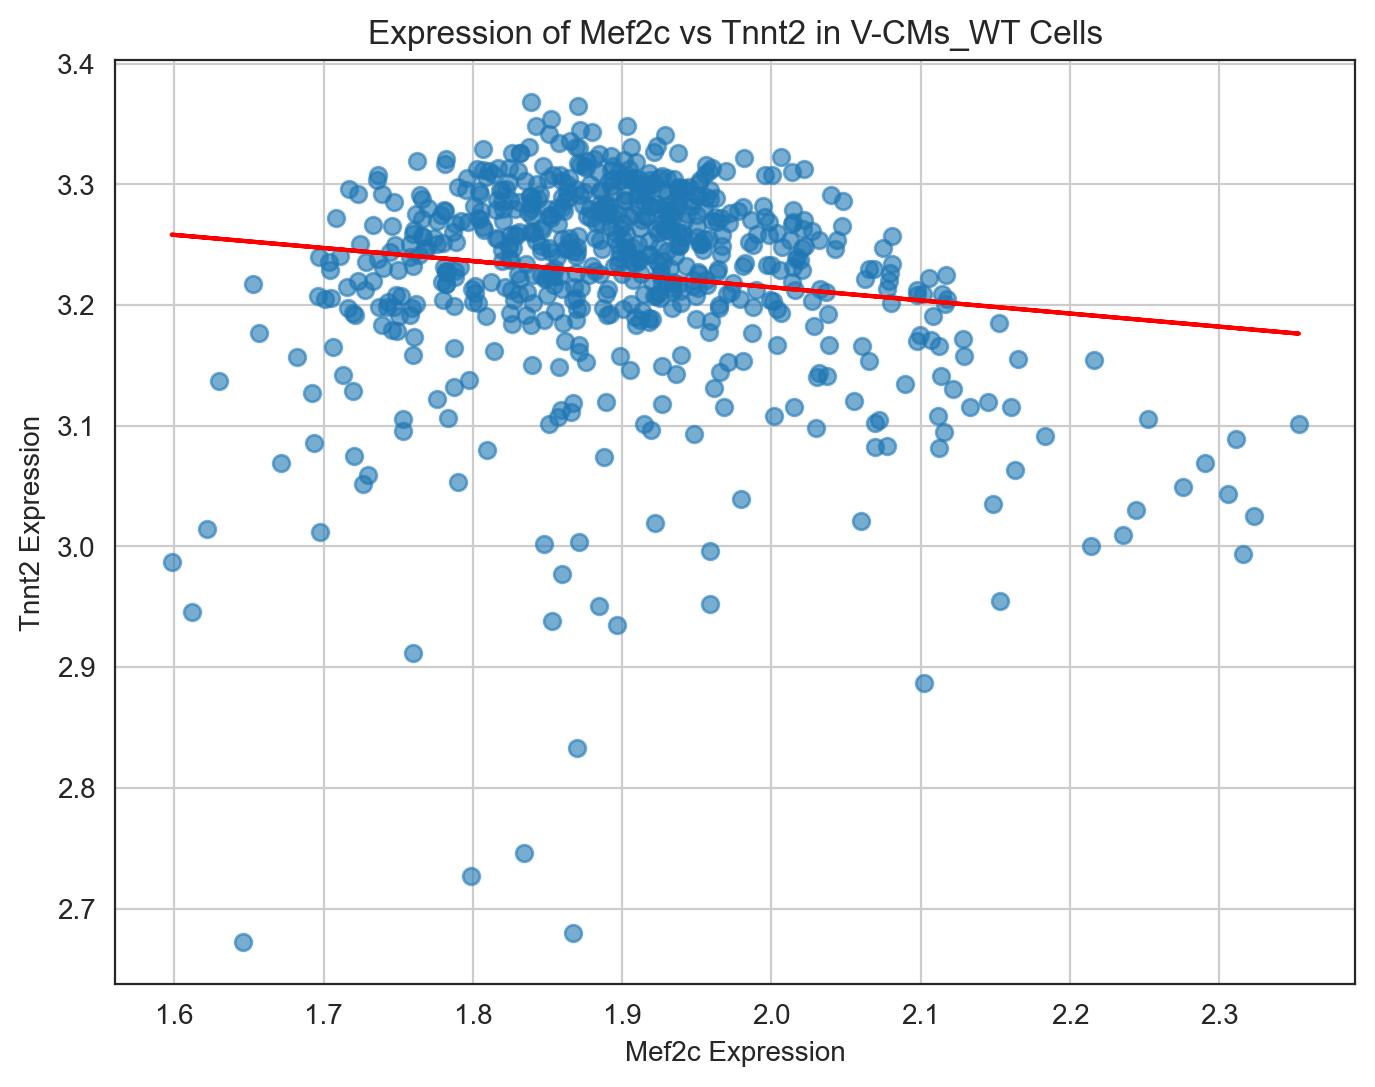

0.01987039471875396
681


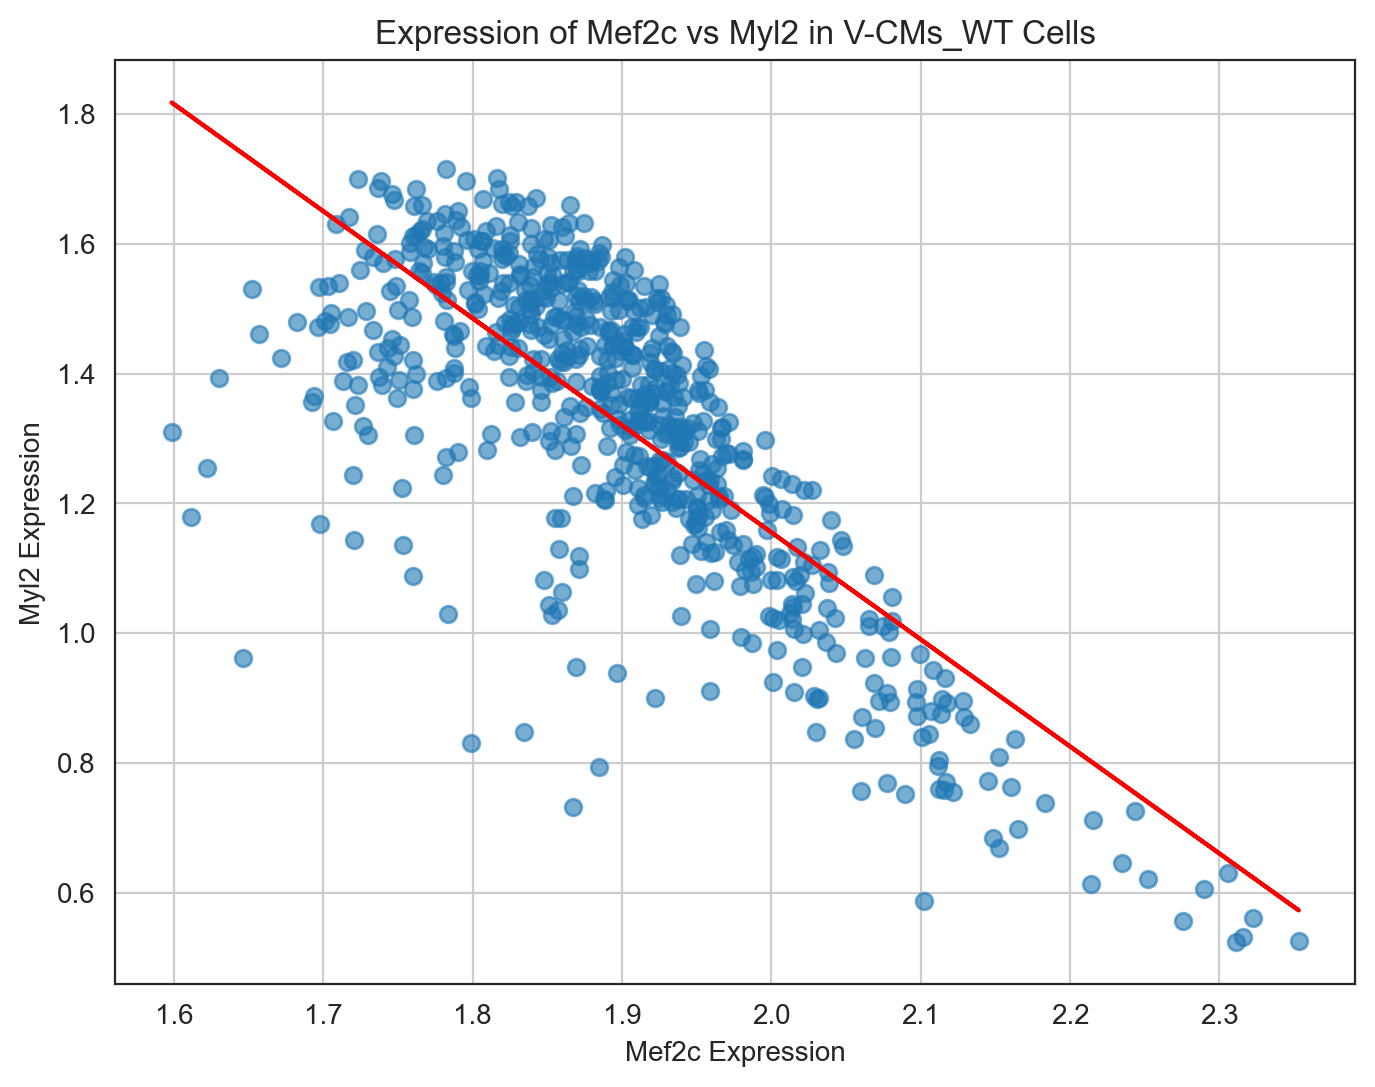

0.5883963604010178
681


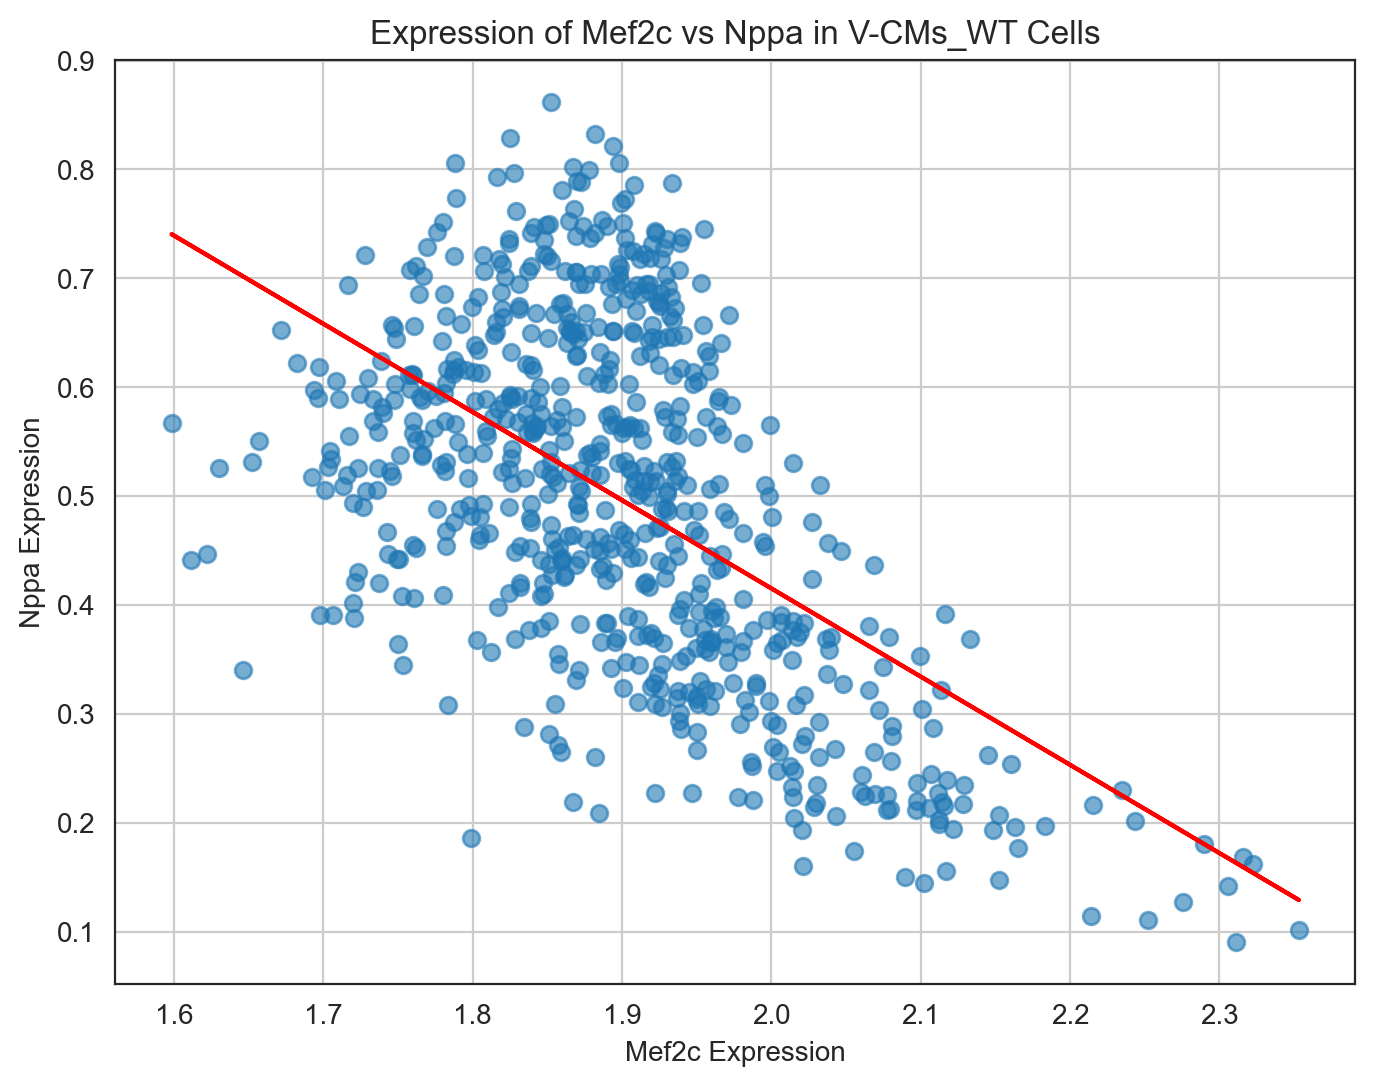

0.3152869781695441


In [43]:
gem_imputed = co.network_analysis.network_construction._adata_to_df(oracle.adata, "imputed_count")

chamber_genotype = 'V-CMs_WT'

imputed_subset = co.network_analysis.network_construction._adata_to_df(oracle.adata[oracle.adata.obs.celltype_x_genotype == chamber_genotype], "imputed_count")

TF = 'Mef2c'
genes_of_interest = ['Wnt2', 'Esrrg', 'Tnnt2', 'Myl2', 'Nppa']

for x in genes_of_interest:
    # Get the expression values for Mef2c and Myh6
    # mef2c_expr = subset[:, 'Mef2c'].X.flatten()  # Ensure the expression matrix is dense
    # myh6_expr = subset[:, x].X.flatten()
    tf_expr = imputed_subset[TF].values
    print(len(tf_expr))
    gene_expr = imputed_subset[x].values

    model = LinearRegression()
    tf_expr_reshaped = tf_expr.reshape(-1, 1)  # Reshape for sklearn
    model.fit(tf_expr_reshaped, gene_expr)

    # Get predictions and R²
    gene_predicted = model.predict(tf_expr_reshaped)
    r2 = r2_score(gene_expr, gene_predicted)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(tf_expr, gene_expr, alpha=0.6)
    plt.plot(tf_expr, gene_predicted, color='red', label=f'Best Fit (R² = {r2:.2f})')
    plt.title(f"Expression of {TF} vs {x} in {chamber_genotype} Cells")
    plt.xlabel(f"{TF} Expression")
    plt.ylabel(f"{x} Expression")
    plt.grid(True)
    plt.show()
    print(r2)

In [31]:
timepoint = '85'

In [32]:
base_GRN = pd.read_parquet(f'data/base_grn_outputs/E85/base_GRN_dataframe.parquet')
base_GRN[base_GRN.gene_short_name == 'Myl2'].Nr2f2

18209    0
18210    0
18211    0
Name: Nr2f2, dtype: int64

In [33]:
base_GRN = pd.read_parquet(f'data/base_grn_outputs/E85/base_GRN_dataframe.parquet')
base_GRN[base_GRN.gene_short_name == 'Myl2'][['peak_id', 'gene_short_name', 'Nr2f2']]

,peak_id,gene_short_name,Nr2f2
18209,chr5_122070912_122071412,Myl2,0
18210,chr5_122100593_122101093,Myl2,0
18211,chr5_122101105_122101605,Myl2,0


In [34]:
base_GRN = pd.read_parquet(f'data/base_grn_outputs/E85/base_GRN_dataframe.parquet')
diffexp = diffexp_ko
removed_indexes = []
for index, row in diffexp.iterrows():
    removed_indexes.append(f"{row['seqnames']}_{row['start']}_{row['end']}")                
base_GRN = base_GRN[~base_GRN.peak_id.isin(removed_indexes)]

NameError: name 'diffexp_ko' is not defined

In [ ]:
base_GRN.Gata4.sum()

In [ ]:
base_GRN[']

In [ ]:
x = links_wt_e85.filtered_links['IFT-CMs_WT']
x[x.target == 'Wnt2'].sort_values('coef_mean')

In [ ]:
x = links_ko_e85.filtered_links['IFT-CMs_KO']
x[x.target == 'Wnt2'].sort_values('coef_mean')

In [ ]:
x = base_GRN
x[x.gene_short_name == 'Myl2'][['peak_id', 'gene_short_name', 'Nr2f2']]

In [49]:
base_GRN_default_atac = co.data.load_mouse_scATAC_atlas_base_GRN()

In [57]:
x = base_GRN_default_atac
x[x.gene_short_name == 'Myl2'][['peak_id', 'gene_short_name', 'Nr2f2']]

,peak_id,gene_short_name,Nr2f2
65148,chr5_122550239_122551222,Myl2,0.0
65151,chr5_122553073_122553707,Myl2,0.0
65210,chr5_122733781_122736230,Myl2,0.0
65237,chr5_122803807_122805255,Myl2,0.0
65273,chr5_122870514_122873334,Myl2,1.0
65289,chr5_122951086_122953637,Myl2,1.0


In [53]:
base_GRN_default_promoter = co.data.load_mouse_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [55]:
x = base_GRN_default_promoter
x[x.gene_short_name == 'Myl2'][['peak_id', 'gene_short_name', 'Nr2f2']]

,peak_id,gene_short_name,Nr2f2
19491,chr5_122099951_122101051,Myl2,0.0


In [74]:
timepoint = 'e9'
adata_e9 = return_adata_raw(timepoint)

In [163]:
links_wt_e85.filtered_links['V-CMs_WT']
x[x.source == 'Nr2f2']

,source,target,coef_mean,coef_abs,p,-logp
4060,Nr2f2,Acta1,-0.016175,0.016175,7.306687e-18,17.136280
188793,Nr2f2,Wnt2,0.011455,0.011455,3.540382e-16,15.450950
9285,Nr2f2,Angpt1,0.008449,0.008449,2.998485e-09,8.523098
149931,Nr2f2,Sema3a,-0.006341,0.006341,5.083961e-16,15.293798
101324,Nr2f2,Mpped2,-0.005753,0.005753,5.101178e-18,17.292330
80134,Nr2f2,Irx4,-0.005618,0.005618,6.821013e-16,15.166151
117100,Nr2f2,Pbx1,0.005471,0.005471,8.150919e-19,18.088793
66842,Nr2f2,Golgb1,0.005250,0.005250,2.184767e-15,14.660595
194821,Nr2f2,Zfpm1,0.005033,0.005033,2.319884e-16,15.634534
176113,Nr2f2,Tnni3,-0.004705,0.004705,5.298358e-11,10.275859


,source,target,coef_mean,coef_abs,p,-logp
100303,Nr2f2,Mpped2,-0.004053,0.004053,3.043808e-16,15.516583
175837,Nr2f2,Tpm1,-0.003718,0.003718,1.434875e-17,16.843186
36353,Nr2f2,Crip1,-0.003037,0.003037,9.290033e-15,14.031983
147634,Nr2f2,Sdk1,-0.002672,0.002672,5.521317e-16,15.257957


In [216]:
x = links_wt_e85.filtered_links['V-CMs_WT']
x[x.target == 'Myl2'].sort_values('coef_mean')
# x[x.cluster == 'V-CMs_WT'].sort_values('betweenness_centrality', ascending=False).head(20)

,source,target,coef_mean,coef_abs,p,-logp
104067,Id4,Myl2,-0.036488,0.036488,2.883149e-14,13.540133
104073,Zic5,Myl2,-0.034800,0.034800,1.001792e-17,16.999223
104124,Creb3l2,Myl2,-0.030285,0.030285,1.576223e-18,17.802382
104118,Pou2f1,Myl2,-0.029447,0.029447,1.563427e-13,12.805922
104077,Mef2c,Myl2,-0.029287,0.029287,2.475882e-22,21.606270
104114,Klf13,Myl2,-0.027401,0.027401,1.110347e-21,20.954541
104116,Klf3,Myl2,-0.026479,0.026479,3.887099e-17,16.410374
104126,Zeb1,Myl2,-0.026008,0.026008,2.216151e-14,13.654401
104095,Id3,Myl2,-0.024959,0.024959,2.210975e-18,17.655416
104115,Nr2c2,Myl2,-0.022647,0.022647,8.502444e-16,15.070456


In [212]:
x = links_ko_e85.filtered_links['V-CMs_KO']
x

,source,target,coef_mean,coef_abs,p,-logp
175405,Nfya,Top2a,0.047899,0.047899,1.175999e-16,15.929593
175403,Smad1,Top2a,0.045293,0.045293,1.692175e-19,18.771555
175396,Brca1,Top2a,0.045173,0.045173,2.038183e-11,10.690757
175401,E2f5,Top2a,0.040586,0.040586,9.116585e-18,17.040168
175407,E2f7,Top2a,0.039011,0.039011,1.545244e-19,18.811003
...,...,...,...,...,...,...
106311,Zic1,Nebl,-0.004310,0.004310,1.600191e-11,10.795828
40949,Tcf7l2,Ddt,-0.004310,0.004310,1.171301e-17,16.931331
34473,Foxd2,Col5a2,-0.004309,0.004309,6.002695e-18,17.221654
74532,Fosb,Hsp90ab1,-0.004309,0.004309,6.161937e-18,17.210283


,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Tcf12,291,0.322616,10,0.011086,281,0.311530,6797.0,0.988543,V-CMs_KO
Chd2,213,0.236142,4,0.004435,209,0.231707,3296.0,0.697729,V-CMs_KO
Zeb1,97,0.107539,4,0.004435,93,0.103104,2336.0,0.420651,V-CMs_KO
Tcf4,18,0.019956,7,0.007761,11,0.012195,2092.0,0.198498,V-CMs_KO
Rfx3,61,0.067627,6,0.006652,55,0.060976,1926.0,0.181855,V-CMs_KO
Mef2a,79,0.087583,6,0.006652,73,0.080931,1723.0,0.395228,V-CMs_KO
Smc3,95,0.105322,7,0.007761,88,0.097561,782.0,0.556941,V-CMs_KO
Foxp1,15,0.016630,7,0.007761,8,0.008869,641.0,0.102989,V-CMs_KO
Smarcc1,48,0.053215,3,0.003326,45,0.049889,627.0,0.177380,V-CMs_KO
E2f7,87,0.096452,4,0.004435,83,0.092018,535.0,0.512886,V-CMs_KO
